<a href="https://colab.research.google.com/github/Nov05/Google-Colaboratory/blob/master/20231229_Temporal_Difference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **\<TOP>**

* changed by nov05 on 2020-05-26, 2023-12-29
* [project folder](https://drive.google.com/drive/folders/10Z8nfMUhGMznM255TTXuao_DLxHyds4T)  
  [cliffwalking.py](https://github.com/openai/gym/blob/master/gym/envs/toy_text/cliffwalking.py)   
  [the solution notebook](https://drive.google.com/file/d/11KKuKGE590XrJDRmLPTcBkyamizrl7L7)  
* [**course on this topic**](https://www.evernote.com/shard/s139/sh/7855877f-4cde-16ac-676a-12c404428d9a/CwI92aC9i4eqdQNbQ3WopqpKF42KmfUaxBGSQJOthSSKHtRuxbIP-2sJyw)  
  [curriculum](https://docs.google.com/document/d/1bX9EdEjIXqOW7nFz8KJvADWCXxoLlRW4_U4B8ojX2eA)  
  [Udacity course](https://learn.udacity.com/nanodegrees/nd893/parts/6f8342e1-2278-4998-a384-283c136c9f69/lessons/1145e877-c407-45cb-93c7-3e93db301529/concepts/9fa15535-e531-4279-8699-2cb56b67f483)    


```
    This is a simple implementation of the Gridworld Cliff
    reinforcement learning task.
    Adapted from Example 6.6 from Reinforcement Learning: An Introduction
    by Sutton and Barto:
    http://people.inf.elte.hu/lorincz/Files/RL_2006/SuttonBook.pdf
    
    With inspiration from:
    https://github.com/dennybritz/reinforcement-learning/blob/master/lib/envs/cliff_walking.py
    The board is a 4x12 matrix, with (using Numpy matrix indexing):
        [3, 0] as the start at bottom-left
        [3, 11] as the goal at bottom-right
        [3, 1..10] as the cliff at bottom-center
    Each time step incurs -1 reward, and stepping into the cliff incurs -100 reward
    and a reset to the start. An episode terminates when the agent reaches the goal.
```

In [2]:
## get the "temporal-difference" folder
!gdown --no-check-certificate --folder https://drive.google.com/drive/folders/10Z8nfMUhGMznM255TTXuao_DLxHyds4T
!pip uninstall -y gym ## colab pre-installed 0.25.2
!pip install gym==0.9.6
import gym
print(gym.__version__)
## restart the session "Ctrl+M."

In [3]:
%cd /content/temporal-difference
!pwd

/content/temporal-difference
/content/temporal-difference


# Temporal-Difference Methods

In this notebook, you will write your own implementations of many Temporal-Difference (TD) methods.

While we have provided some starter code, you are welcome to erase these hints and write your code from scratch.

* **Temporal_Difference.ipynb** - the Jupyter notebook where you will write all of your implementations (this is the only file that you will modify!)  
* **Temporal_Difference_Solution.ipynb** - the corresponding instructor solutions
* **plot_utils.py** - contains a plotting function for visualizing state-value functions and policies
* **check_test.py** - contains unit tests to check the validity of your implementations

<img src="https://github.com/Nov05/pictures/blob/master/Udacity/20231221_reinforcement%20learning/2023-12-28%2023_22_22-Temporal-Difference%20Methods_sarsa%20comparison.jpg?raw=true" width=500>
---

### Part 0: Explore CliffWalkingEnv

We begin by importing the necessary packages.



In [4]:
import sys
import gym
import numpy as np
from collections import defaultdict, deque
import matplotlib.pyplot as plt
%matplotlib inline

import check_test
from plot_utils import plot_values

Use the code cell below to create an instance of the [CliffWalking](https://github.com/openai/gym/blob/master/gym/envs/toy_text/cliffwalking.py) environment.

In [5]:
env = gym.make('CliffWalking-v0')

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


The agent moves through a $4\times 12$ gridworld, with states numbered as follows:
```
[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]]
```
At the start of any episode, state `36` is the initial state.  State `47` is the only terminal state, and the cliff corresponds to states `37` through `46`.

The agent has 4 potential actions:
```
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3
```

Thus, $\mathcal{S}^+=\{0, 1, \ldots, 47\}$, and $\mathcal{A} =\{0, 1, 2, 3\}$.  Verify this by running the code cell below.

In [55]:
print(env.action_space)
print(env.observation_space)

Discrete(4)
Discrete(48)


In this mini-project, we will build towards finding the optimal policy for the CliffWalking environment.  The optimal state-value function is visualized below.  Please take the time now to make sure that you understand _why_ this is the optimal state-value function.

_**Note**: You can safely ignore the values of the cliff "states" as these are not true states from which the agent can make decisions.  For the cliff "states", the state-value function is not well-defined._

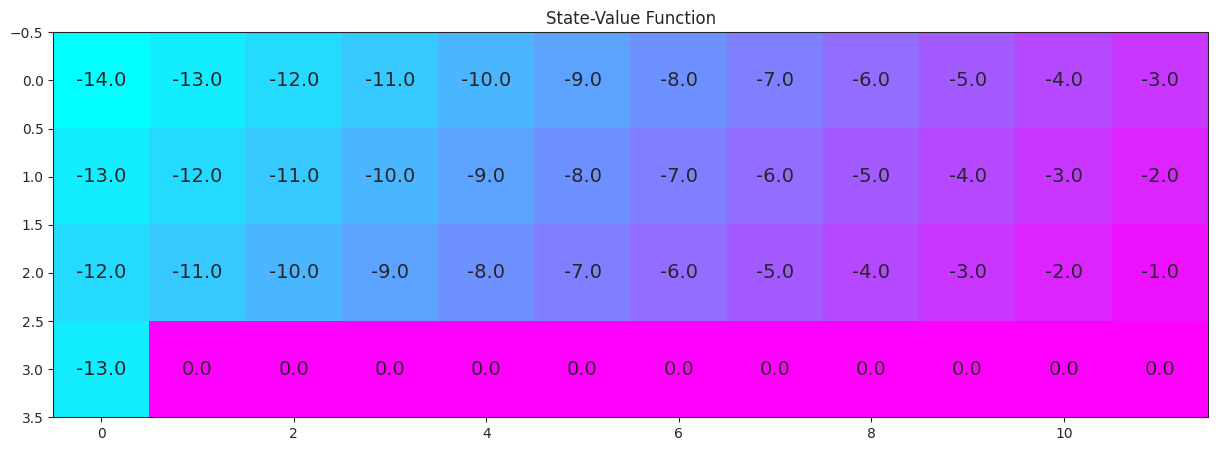

In [7]:
## define the optimal state-value function
V_opt = np.zeros((4,12))
V_opt[0:13][0] = -np.arange(3, 15)[::-1]
V_opt[0:13][1] = -np.arange(3, 15)[::-1] + 1
V_opt[0:13][2] = -np.arange(3, 15)[::-1] + 2
V_opt[3][0] = -13
plot_values(V_opt)

### Part 1: TD Control: Sarsa

In this section, you will write your own implementation of the Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)  

<img src="https://github.com/Nov05/pictures/blob/master/Udacity/20231221_reinforcement%20learning/13_sarsa.jpg?raw=true" width=500>

In [43]:
import random
from tqdm import tqdm

def sarsa(env, num_episodes, alpha, gamma=1.0):
    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(nA))
    scores = []
    for i_episode in tqdm(range(1, num_episodes+1), desc="Episodes", position=0, leave=True):
        ## TODO: complete the function
        epsilon = 1. / i_episode ## this affects the scale of the state-values hugely
        state = env.reset()
        action = get_action(Q, state, nA, epsilon)
        score = 0
        while True:
            next_state, reward, done, info = env.step(action)
            score += reward
            if done:
                update_Q_sarsa(Q, alpha, gamma,
                               state, action, reward, None, None)
                scores.append(score)
                break
            next_action = get_action(Q, next_state, nA, epsilon)
            update_Q_sarsa(Q, alpha, gamma,
                        state, action, reward, next_state, next_action)
            state, action, reward, next_state, next_action = next_state, next_action, None, None, None
    return Q, scores

def get_action(Q, state, nA, epsilon):
    if state in Q: ## Ɛ-greedy(Q)
        policy_s = get_policy_for_state(Q[state], nA, epsilon=epsilon)
        return np.random.choice(np.arange(nA), p=policy_s)
    else: ## equiprobable random policy
        return env.action_space.sample()
    # if random.random() > eps: ## select greedy action with probability epsilon
    #     return np.argmax(Q[state])
    # else:  ## otherwise, select an action randomly
    #     return random.choice(np.arange(env.action_space.n))

def get_policy_for_state(Q_s, nA, epsilon): ## Ɛ-greedy(Q)
    policy_s = epsilon/nA * np.ones(nA)
    policy_s[np.argmax(Q_s)] = 1 - epsilon + epsilon/nA
    return policy_s

def update_Q_sarsa(Q, alpha, gamma,
                   state, action, reward, next_state=None, next_action=None):
    ## CAUTION: next_state could be 0
    Q_sa_next = Q[next_state][next_action] if next_state is not None else 0
    Q[state][action] = (1-alpha) * Q[state][action] + \
                        alpha * (reward + gamma*Q_sa_next)

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episodes: 100%|██████████| 5000/5000 [00:09<00:00, 506.29it/s] 


**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 0  1  3  1  2  1  1  1  3  1  2  2]
 [ 1  1  1  0  1  1  2  1  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


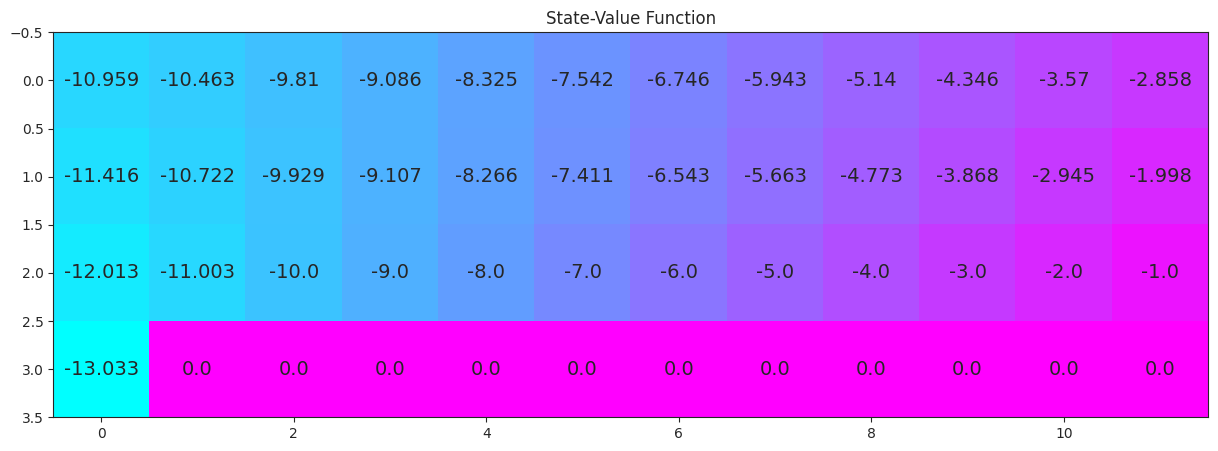

CPU times: user 9.74 s, sys: 253 ms, total: 9.99 s
Wall time: 10.4 s


In [44]:
%%time
## obtain the estimated optimal policy and corresponding action-value function
Q_sarsa, scores = sarsa(env, 5000, .01) ## env, num_episodes=5000, alpha

## print the estimated optimal policy
policy_sarsa = np.array([np.argmax(Q_sarsa[key]) if key in Q_sarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_sarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsa)

## plot the estimated optimal state-value function
V_sarsa = ([np.max(Q_sarsa[key]) if key in Q_sarsa else 0 for key in np.arange(48)])
plot_values(V_sarsa)

Best Average Reward over 100 Episodes: -13.0


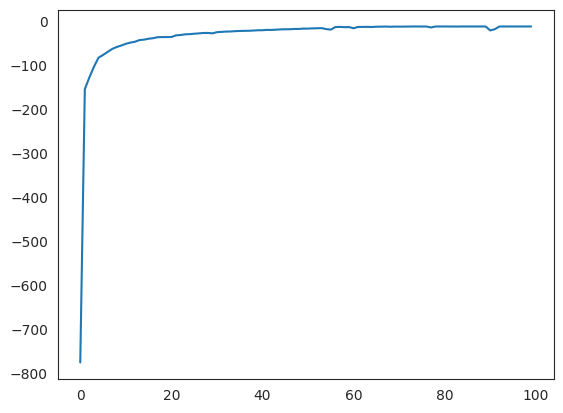

In [50]:
import numpy as np
import matplotlib.pyplot as plt
data = np.array(scores).reshape(100, -1).mean(axis=1)
print(f"Best Average Reward over 100 Episodes: {data.max()}")
plt.plot(data);

### Part 2: TD Control: Q-learning

In this section, you will write your own implementation of the Q-learning control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

<img src="https://github.com/Nov05/pictures/blob/master/Udacity/20231221_reinforcement%20learning/14_sarsamax%20(Q-Learning).jpg?raw=true" width=500>

In [52]:
import random
from tqdm import tqdm

def q_learning(env, num_episodes, alpha, gamma=1.0):
    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(nA))
    scores = []
    for i_episode in tqdm(range(1, num_episodes+1), desc="Episodes", position=0, leave=True):
        ## TODO: complete the function
        epsilon = 1. / i_episode ## this affects the scale of the state-values hugely
        state = env.reset()
        action = get_action(Q, state, nA, epsilon)
        score = 0
        while True:
            next_state, reward, done, info = env.step(action)
            score += reward
            if done:
                update_Q_sarsamax(Q, alpha, gamma,
                                  state, action, reward, None, None)
                scores.append(score)
                break
            next_action = get_action(Q, next_state, nA, epsilon)
            update_Q_sarsamax(Q, alpha, gamma,
                              state, action, reward, next_state, next_action)
            state, action, reward, next_state, next_action = next_state, next_action, None, None, None
    return Q, scores

def get_action(Q, state, nA, epsilon):
    if state in Q: ## Ɛ-greedy(Q)
        policy_s = get_policy_for_state(Q[state], nA, epsilon=epsilon)
        return np.random.choice(np.arange(nA), p=policy_s)
    else: ## equiprobable random policy
        return env.action_space.sample()

def get_policy_for_state(Q_s, nA, epsilon): ## Ɛ-greedy(Q)
    policy_s = epsilon/nA * np.ones(nA)
    policy_s[np.argmax(Q_s)] = 1 - epsilon + epsilon/nA
    return policy_s

def update_Q_sarsamax(Q, alpha, gamma,
                      state, action, reward, next_state=None, next_action=None):
    ## CAUTION: next_state could be 0
    Q_sa_next = Q[next_state].max() if next_state is not None else 0
    Q[state][action] = (1-alpha) * Q[state][action] + \
                        alpha * (reward + gamma*Q_sa_next)

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episodes: 100%|██████████| 5000/5000 [00:10<00:00, 493.59it/s]


**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  2  1  1  1  0  1  1  1  1  2  2]
 [ 0  1  1  2  0  1  2  1  1  2  2  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


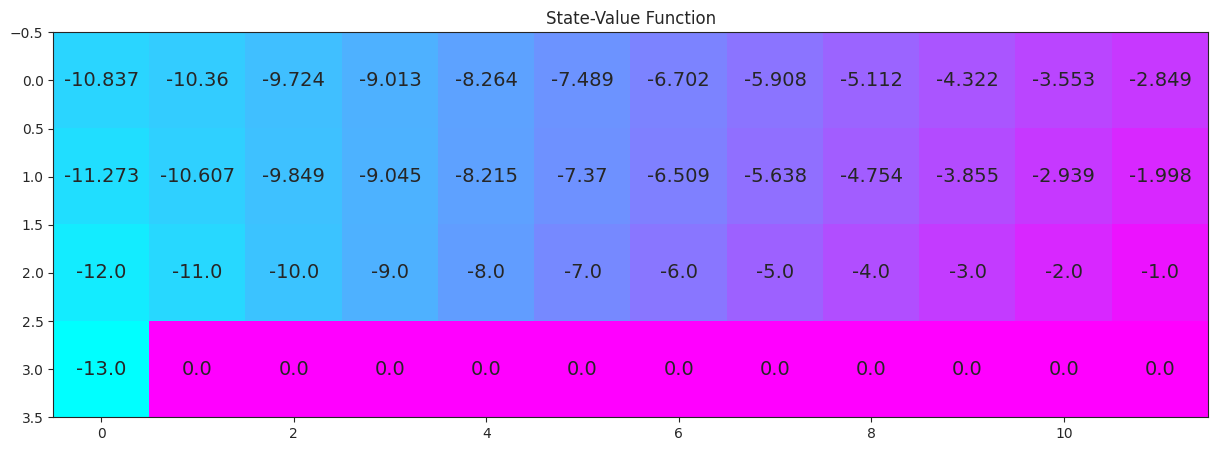

In [53]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsamax, scores = q_learning(env, 5000, .01)

# print the estimated optimal policy
policy_sarsamax = np.array([np.argmax(Q_sarsamax[key]) if key in Q_sarsamax else -1 for key in np.arange(48)]).reshape((4,12))
check_test.run_check('td_control_check', policy_sarsamax)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsamax)

# plot the estimated optimal state-value function
plot_values([np.max(Q_sarsamax[key]) if key in Q_sarsamax else 0 for key in np.arange(48)])

Best Average Reward over 100 Episodes: -13.0


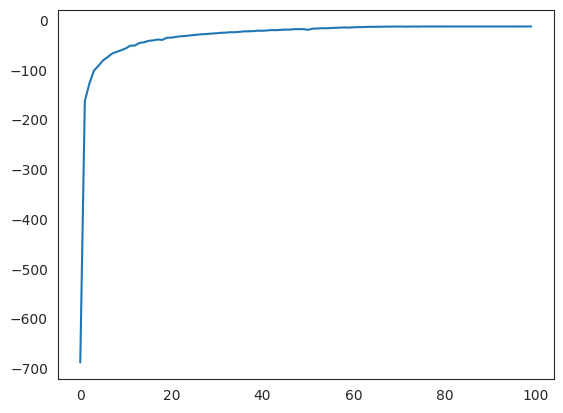

In [54]:
import numpy as np
import matplotlib.pyplot as plt
data = np.array(scores).reshape(100, -1).mean(axis=1)
print(f"Best Average Reward over 100 Episodes: {data.max()}")
plt.plot(data);

### Part 3: TD Control: Expected Sarsa

In this section, you will write your own implementation of the Expected Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

<img src="https://github.com/Nov05/pictures/blob/master/Udacity/20231221_reinforcement%20learning/15_expected%20sarsa.jpg?raw=true" width=500>

In [146]:
import random
from tqdm import tqdm

def expected_sarsa(env, num_episodes, alpha, gamma=1.0):
    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(nA))
    scores = []
    for i_episode in tqdm(range(1, num_episodes+1), desc="Episodes", position=0, leave=True):
        ## TODO: complete the function
        epsilon = 0.005 ## this affects the scale of the state-values hugely
        state = env.reset()
        score = 0
        while True:
            action = get_action(Q, state, nA, epsilon)
            next_state, reward, done, info = env.step(action)
            score += reward
            update_Q_expsarsa(Q, nA, alpha, gamma, epsilon,
                              state, action, reward, next_state)
            state, reward, next_state = next_state, None, None
            if done:
                scores.append(score)
                break
    return Q, scores

def get_action(Q, state, nA, epsilon):
    if state in Q: ## Ɛ-greedy(Q)
        policy_s = get_policy_for_state(Q[state], nA, epsilon=epsilon)
        return np.random.choice(np.arange(nA), p=policy_s)
    else: ## equiprobable random policy
        return env.action_space.sample()

def get_policy_for_state(Q_s, nA, epsilon): ## Ɛ-greedy(Q)
    policy_s = epsilon/nA * np.ones(nA)
    policy_s[np.argmax(Q_s)] = 1 - epsilon + epsilon/nA
    return policy_s

def update_Q_expsarsa(Q, nA, alpha, gamma, epsilon,
                      state, action, reward, next_state=None):
    if next_state is None:
        Q_sa_next = 0
    else:
        policy_next = get_policy_for_state(Q[next_state], nA, epsilon)
        Q_sa_next = np.dot(policy_next, Q[next_state])
    Q[state][action] = (1-alpha) * Q[state][action] + \
                        alpha * (reward + gamma * Q_sa_next)

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episodes: 100%|██████████| 10000/10000 [00:10<00:00, 928.17it/s]


**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  1  1  1  1  2  1  1  1  1  2  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


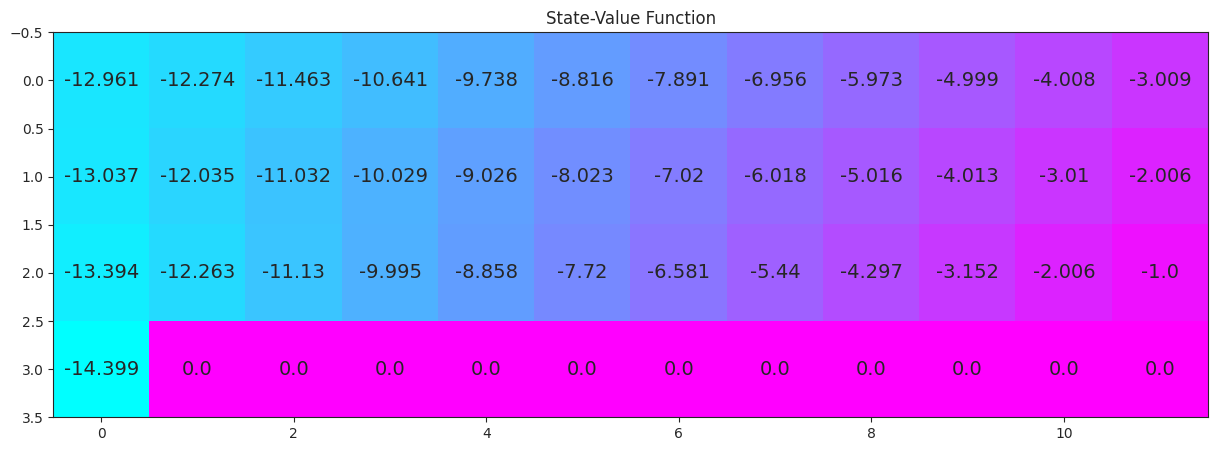

In [147]:
# obtain the estimated optimal policy and corresponding action-value function
Q_expsarsa, scores = expected_sarsa(env, 10000, 0.9)

# print the estimated optimal policy
policy_expsarsa = np.array([np.argmax(Q_expsarsa[key]) if key in Q_expsarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_expsarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_expsarsa)

# plot the estimated optimal state-value function
plot_values([np.max(Q_expsarsa[key]) if key in Q_expsarsa else 0 for key in np.arange(48)])

Best Average Reward over 100 Episodes: -13.0


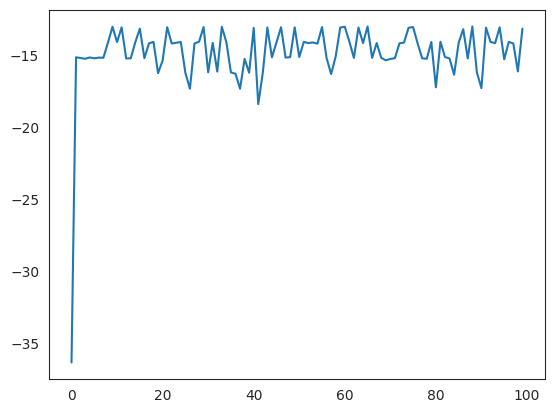

In [148]:
import numpy as np
import matplotlib.pyplot as plt
data = np.array(scores).reshape(100, -1).mean(axis=1)
print(f"Best Average Reward over 100 Episodes: {data.max()}")
plt.plot(data);

# **\<BOTTOM>**  